# Experiment 13: 13_trying_probs_tfms

Using best hps from 12 per organ, and testing different transform probabilities.

Prostate: 0.2

Spleen: 0.9

Lung: 0.8

Kidney: 0.6

Large Intestine: 0.8

In [1]:
EXP_NAME = "13_trying_probs_tfms"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import monai
from typing import Union, Tuple, Any
from pathlib import Path
Path.ls = lambda p: list(p.iterdir())
from functools import partial
from fastai.data.transforms import get_image_files
import catalyst
from catalyst import dl
import segmentation_models_pytorch as smp
import albumentations as A
import itertools

# Lookahead imports
from typing import Callable, Dict, Optional
from collections import defaultdict
import torch
from torch.optim import Optimizer

In [3]:
def get_device(verbose: bool = True) -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        if verbose: print("Using the GPU!")
    else:
        device = torch.device("cpu")
        if verbose: print("Using the CPU!")
    return device
    
def load_image_monai(fn: Union[Path, str]) -> np.array:
    image_array = monai.transforms.LoadImage(image_only=True)(str(fn))
    return image_array.__array__().astype(np.uint8)

def plot_image_mask(image: np.array, mask: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if not isinstance(mask, type(np.array([0]))): mask = mask.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    if len(mask.shape) == 3 and mask.shape[0] > 1: mask = mask[0]
    plt.figure(figsize=figsize)
    if image.mean() > 1: plt.imshow(image.astype(np.uint8), interpolation="none")
    else: plt.imshow(image.astype(np.float32), interpolation="none")
    plt.imshow(mask.astype(np.uint8), cmap="jet", alpha=0.5)
    
def plot_image(image: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="none")

def fn2image(fn: Union[Path, str]) -> np.array:
    return load_image_monai(fn)

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2fn(fid: str) -> Path:
    return COMBINED_DF[COMBINED_DF.id == int(fid)]["fnames"].values[0]

def id2rle(fid: str) -> str:
    rle = TRAIN_DF[TRAIN_DF.id==int(fid)]["rle"].values[0]
    return rle

def fn2rle(fn: Union[Path, str]) -> str:
    fid = fn2id(fn)
    return id2rle(fid)

def id2organ(fid: str) -> str:
    organ = TRAIN_DF[TRAIN_DF.id==int(fid)]["organ"].values[0]
    return organ

def id2shape(fid: str) -> Tuple[int, int]:
    width = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_width"].values[0]
    height = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_height"].values[0]
    return width, height

def fn2shape(fn: Union[Path, str]) -> Tuple[int, int]:
    fid = fn2id(fn)
    return id2shape(fid)

def load_mask(fn: Union[Path, str]) -> np.array:
    shape = fn2shape(fn)
    rle = fn2rle(fn)
    return rle_decode(rle, shape)

def fn2mask(fn: Union[Path, str]) -> np.array:
    return load_mask(fn)

def id2mask(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2mask(fn)

def save_df(df:Dict[str, Any], df_file:str, replace:bool=False):
    if replace: return pd.DataFrame(df).to_csv(df_file, index=False)
    try: 
        d = pd.read_csv(df_file)
        d = pd.concat([d, pd.DataFrame(df)])
    except FileNotFoundError: 
        d = pd.DataFrame(df)
    d.to_csv(df_file, index=False)

def load_df(df_file: str) -> pd.DataFrame:
    try:  df = pd.read_csv(df_file)
    except FileNotFoundError: df = None
    return df

In [4]:
def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

In [5]:
# From: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return np.reshape(img, shape)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
def split_df_train_test(df, colname, seed=9210, test_pct=0.2):
    df = df.copy()
    np.random.seed(seed)
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    test_ids = df.id.values[indices[:int(test_pct*len(indices))]]
    df[colname] = df.id.apply(lambda fid: fid in test_ids)
    return df

In [7]:
class Lookahead(Optimizer):
    """Implements Lookahead algorithm.

    It has been proposed in `Lookahead Optimizer: k steps forward,
    1 step back`_.

    Main origins of inspiration:
        https://github.com/alphadl/lookahead.pytorch (MIT License)

    .. _`Lookahead Optimizer\: k steps forward, 1 step back`:
        https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer: Optimizer, k: int = 5, alpha: float = 0.5):
        """@TODO: Docs. Contribution is welcome."""
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0


    def update(self, group):
        """@TODO: Docs. Contribution is welcome."""
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)


    def update_lookahead(self):
        """@TODO: Docs. Contribution is welcome."""
        for group in self.param_groups:
            self.update(group)


    def step(self, closure: Optional[Callable] = None):
        """Makes optimizer step.

        Args:
            closure (callable, optional): A closure that reevaluates
                the model and returns the loss.
        """
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss


    def state_dict(self):
        """@TODO: Docs. Contribution is welcome."""
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }


    def load_state_dict(self, state_dict):
        """@TODO: Docs. Contribution is welcome."""
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state


    def add_param_group(self, param_group):
        """@TODO: Docs. Contribution is welcome."""
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)


    @classmethod
    def get_from_params(
        cls, params: Dict, base_optimizer_params: Dict = None, **kwargs,
    ) -> "Lookahead":
        """@TODO: Docs. Contribution is welcome."""
        from catalyst.dl.registry import OPTIMIZERS

        base_optimizer = OPTIMIZERS.get_from_params(
            params=params, **base_optimizer_params
        )
        optimizer = cls(optimizer=base_optimizer, **kwargs)
        return optimizer

In [8]:
TRAIN_DF = pd.read_csv("../data/train.csv")
TEST_DF = pd.read_csv("../data/test.csv")

TRAIN_IMAGES = get_image_files("../data/train_images")
TEST_IMAGES = get_image_files("../data/test_images")
ALL_IMAGES = [*TRAIN_IMAGES, *TEST_IMAGES]

In [9]:
KEYS = ["image", "label"]
IMAGE = "image"
LABEL = "label"
DEVICE = get_device()
#TRANSFORM_PROB = 0.5
CROP_SIZE = (2700, 2700)
IMAGE_SIZE = (256, 256)
MIN_CROP_SIZE = (160, 160) # Smallest imagesize in hidden testset (https://www.kaggle.com/competitions/hubmap-organ-segmentation/data)
EPOCHS = 200
ACCUM_STEPS = 1
BATCH_SIZE = 8
LR_BS = 4.6875e-05
LR = LR_BS * BATCH_SIZE * ACCUM_STEPS
EARLY_STOP_PATIENCE = 50
ENCODER = "efficientnet-b3"
WEIGHT_DECAYS = {
    "prostate": 0.0001,
    "spleen": 0.01,
    "lung": 0.001,
    "kidney": 0.0001,
    "largeintestine": 0.0001,
}
MOMENTUMS = {
    "prostate": 0.95,
    "spleen": 0.95,
    "lung": 0.9,
    "kidney": 0.9,
    "largeintestine": 0.99,
}

LOG_DIR = Path("../logs")/EXP_NAME
LOG_DIR.mkdir(exist_ok=True)

Using the GPU!


In [10]:
def add_fnames(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    fnames = []
    for fid in df.id.values: fnames.append([fname for fname in ALL_IMAGES if str(fid) in fname.stem][0])
    df["fnames"] = fnames
    return df

In [11]:
def test_model(
        model:torch.nn.Module, 
        dl:monai.data.DataLoader, 
        metric_func:callable, 
        threshold:float=0.5) -> float:
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in tqdm(iter(dl), total=len(dl)):
            X, y = data[IMAGE].to(DEVICE), data[LABEL]
            y_hat = model(X).detach().cpu()
            preds = [*preds, *[logit_process(i) for i in y_hat]]
            trues = [*trues, *[i for i in monai.data.decollate_batch(y)]]
    metric_func(preds, trues)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

def load_weights(model:torch.nn.Module, weights_path:Union[str,Path], device:torch.device=DEVICE)->torch.nn.Module:
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device)

In [12]:
def make3D(t: np.array) -> np.array:
    t = np.expand_dims(t, axis=2)
    t = np.concatenate((t,t,t), axis=2)
    return t

def plot_results(model, dl, threshold=0.5, figsize=10):
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    max_size = 2**16
    model = model.to(DEVICE)
    model.eval()
    ims, preds, labels = [], [], []
    with torch.no_grad():
        for item in tqdm(iter(dl), total=len(dl)):
            X, y = item[IMAGE].to(DEVICE), item[LABEL].cpu()
            y_hat = model(X).detach().cpu()
            ims = [*ims, *[im.numpy() for im in X.detach().cpu()]]
            preds = [*preds, *[logit_process(pred).numpy() for pred in y_hat]]
            labels = [*labels, *[lbl.numpy() for lbl in y]]
    
    vs = []
    for i, b in enumerate(range(len(preds))):
        if (i+1) * preds[0].shape[1] * figsize > max_size:
            print("Dataset to big, only displaying a portion of it!")
            break
        
        im = np.einsum("cwh->whc", ims[b])
        pred = make3D(preds[b][1])
        label = make3D(labels[b][1])
        vs.append(np.hstack((im, pred, label)))
    

    plt.figure(figsize=(figsize, figsize*len(vs)))
    plt.title("Input / Prediction / Target")
    plt.imshow(np.vstack(vs))

def one_batch(
        dl:monai.data.DataLoader, 
        b_idx:int=0, 
        unpacked:bool=False) -> Union[Dict[str, Any], Tuple[torch.Tensor, torch.Tensor]]:
    assert b_idx < len(dl), f"DataLoader only has {len(dl)} batches..."
    for i, items in enumerate(iter(dl)):
        if i == b_idx: 
            if unpacked:
                X, y = items[IMAGE].to(DEVICE), items[LABEL].to(DEVICE)
                return X, y
            return items
def batch2numpy(batch:Dict[str,torch.Tensor])->Tuple[np.array]:
    return batch[IMAGE].detach().cpu().numpy(), batch[LABEL].detach().cpu().numpy()
def plot_batch(batch:Dict[str, torch.Tensor], figsize:int=10):
    X, y = batch2numpy(batch)
    vstacks = []
    for b in range(X.shape[0]):
        im = X[b].transpose(1, 2, 0)
        msk = make3D(y[b, 1])
        vstacks.append(np.hstack((im,msk)))
    patchwork = np.vstack(vstacks)
    plt.figure(figsize=(figsize, figsize*X.shape[0]))
    plt.imshow(patchwork)

In [13]:
TRAIN_DF = add_fnames(TRAIN_DF)
TEST_DF = add_fnames(TEST_DF)
COMBINED_DF = pd.concat([TRAIN_DF, TEST_DF])
COMBINED_DF.drop(columns="rle").head(2)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,fnames
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,../data/train_images/10274.tiff


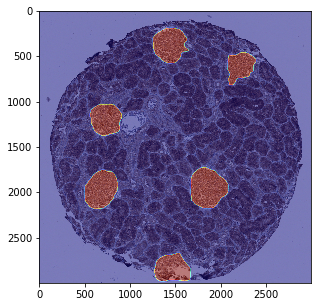

In [14]:
fn = np.random.choice(TRAIN_DF.fnames.values)
im = load_image_monai(fn)
mask = fn2mask(fn)
plot_image_mask(im, mask, figsize=(5, 5))

In [15]:
def alb_wrapper(arr, f):
    datatype = arr.dtype
    arr = torch.einsum("cwh->whc", arr) * 255.
    arr = f(image=arr.numpy().astype(np.uint8))["image"]
    arr = torch.Tensor(arr).to(datatype) / 255.
    return torch.einsum("whc->cwh", arr)
huesat = partial(alb_wrapper, f=A.HueSaturationValue(
    p=1, 
    hue_shift_limit=80,
    sat_shift_limit=80, 
    val_shift_limit=80, 
    always_apply=True))

In [16]:
def get_load_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
    ])

def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        *get_load_transforms().transforms,

        monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
        
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad((IMAGE,), huesat),
        
        monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandCoarseShuffled((IMAGE,), 
            holes=2, 
            max_holes=15, 
            spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
            max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
            prob=TRANSFORM_PROB),

        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_valid_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_test_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.EnsureTypeD(KEYS)
])

In [17]:
TRANSFORM_PROBS = [0.2, 0.4, 0.6, 0.8, 0.9]

In [18]:
metrics_log = {"organ": [], "transform_probability": [], "train_dice": [], "valid_dice": [], "test_dice": []}

HPS = list(itertools.product(TRAIN_DF.organ.unique(), TRANSFORM_PROBS))

for organ, TRANSFORM_PROB in HPS:

    momentum = MOMENTUMS[organ]
    weight_decay = WEIGHT_DECAYS[organ]
    
    organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
    organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
    organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
    organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
    assert len(organ_testset_df.organ.unique()) == 1
    assert len(organ_train_valid_df.organ.unique()) == 1
    del organ_train_test_df

    train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
    valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
    test_ids = organ_testset_df.id.values
    assert len(set(train_ids).intersection(set(valid_ids))) == 0
    assert len(set(train_ids).intersection(set(test_ids))) == 0
    assert len(set(valid_ids).intersection(set(test_ids))) == 0

    data_dicts = {
        "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
        "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
        "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
    }

    train_ds = monai.data.CacheDataset(data_dicts["train"], transform=get_train_transforms())
    valid_ds = monai.data.CacheDataset(data_dicts["valid"], transform=get_valid_transforms())
    test_ds  = monai.data.CacheDataset(data_dicts["test"],  transform=get_test_transforms())

    train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    loaders = {"train": train_dl, "valid": valid_dl}

    model = smp.Unet(
        encoder_name=ENCODER,        
        encoder_weights="imagenet",     
        in_channels=3,                  
        classes=2,  
    )

    criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR, betas=(momentum, 0.999), weight_decay=weight_decay))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

    dice_func = partial(
        calc_metric, 
        metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

    callbacks = [
        catalyst.dl.FunctionalMetricCallback(
        input_key="logits",
        target_key=LABEL,
        metric_fn=dice_func,
        metric_key="dice"
        ),
        catalyst.dl.OptimizerCallback(
            metric_key="loss", 
            accumulation_steps=ACCUM_STEPS),
        catalyst.dl.EarlyStoppingCallback(
            patience=EARLY_STOP_PATIENCE, 
            loader_key="valid", 
            metric_key="loss",
            min_delta=1e-3,
            minimize=True)
    ]

    runner = catalyst.dl.SupervisedRunner(
        input_key=IMAGE, 
        output_key="logits", 
        target_key=LABEL, 
        loss_key="loss"
    )

    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loaders,
        num_epochs=EPOCHS,
        callbacks=callbacks,
        logdir=LOG_DIR/f"{organ}_tfp{TRANSFORM_PROB}",
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
        verbose=False,
        timeit=False,
        load_best_on_end=True
    )

    dice_metric = monai.metrics.DiceMetric(
        include_background=False, 
        reduction="mean")

    train_dice = test_model(model, train_dl, metric_func=dice_metric)
    valid_dice = test_model(model, valid_dl, metric_func=dice_metric)
    test_dice = test_model(model, test_dl, metric_func=dice_metric)

    metrics_log["organ"].append(organ)
    metrics_log["transform_probability"].append(TRANSFORM_PROB)
    metrics_log["train_dice"].append(train_dice)
    metrics_log["valid_dice"].append(valid_dice)
    metrics_log["test_dice"].append(test_dice)
    save_df(metrics_log, LOG_DIR/"metrics.csv", replace=True)

print("Done.")

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


train (1/200) dice: 0.31579867268309875 | dice/mean: 0.31579867268309875 | dice/std: 0.060024563009177585 | loss: 1.0046770362293018 | loss/mean: 1.0046770362293018 | loss/std: 0.057259537141772565 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.26076002418994904 | dice/mean: 0.26076002418994904 | dice/std: 0.010731267620697421 | loss: 0.930745542049408 | loss/mean: 0.930745542049408 | loss/std: 0.01761898098788851 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.335887809010113 | dice/mean: 0.335887809010113 | dice/std: 0.058411834479659835 | loss: 0.9821230243234074 | loss/mean: 0.9821230243234074 | loss/std: 0.09716630958854673 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.2316315472126007 | dice/mean: 0.2316315472126007 | dice/std: 0.010143698419010035 | loss: 0.8777848482131958 | loss/mean: 0.8777848482131958 | loss/std: 0.012143332812620282 | lr: 0.00033919068644530263 | momentum: 0.95
* 

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s]


train (1/200) dice: 0.32978258413427014 | dice/mean: 0.32978258413427014 | dice/std: 0.060401354395689576 | loss: 0.9229252969517429 | loss/mean: 0.9229252969517429 | loss/std: 0.06786466689901878 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.2532898038625717 | dice/mean: 0.2532898038625717 | dice/std: 0.011348893205498443 | loss: 0.9310945868492126 | loss/mean: 0.9310945868492126 | loss/std: 0.014682350777846851 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.32109275109627666 | dice/mean: 0.32109275109627666 | dice/std: 0.0860708237748291 | loss: 0.9201639960793888 | loss/mean: 0.9201639960793888 | loss/std: 0.08185896149459007 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.19368833303451538 | dice/mean: 0.19368833303451538 | dice/std: 0.011981831694138722 | loss: 0.9124827086925507 | loss/mean: 0.9124827086925507 | loss/std: 0.011577878829844462 | lr: 0.00033919068644530263 | momentum: 0.9

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s]


train (1/200) dice: 0.33319070759941555 | dice/mean: 0.33319070759941555 | dice/std: 0.06359065186270127 | loss: 0.9236475089017082 | loss/mean: 0.9236475089017082 | loss/std: 0.0683132607923435 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.25315579771995544 | dice/mean: 0.25315579771995544 | dice/std: 0.01114548551701257 | loss: 0.9298173487186432 | loss/mean: 0.9298173487186432 | loss/std: 0.01465437202490236 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.32394879705765667 | dice/mean: 0.32394879705765667 | dice/std: 0.08595769491694712 | loss: 0.9184368568308213 | loss/mean: 0.9184368568308213 | loss/std: 0.08313787693211964 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.19720251113176346 | dice/mean: 0.19720251113176346 | dice/std: 0.012404413975616318 | loss: 0.9103706181049347 | loss/mean: 0.9103706181049347 | loss/std: 0.011739841643919165 | lr: 0.00033919068644530263 | momentum: 0.95

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


train (1/200) dice: 0.3335804991862353 | dice/mean: 0.3335804991862353 | dice/std: 0.06204454162139291 | loss: 0.9258257501265582 | loss/mean: 0.9258257501265582 | loss/std: 0.06642951764471898 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.2509795278310776 | dice/mean: 0.2509795278310776 | dice/std: 0.011405066169330891 | loss: 0.9293136596679688 | loss/mean: 0.9293136596679688 | loss/std: 0.01461679000362049 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.32460810331737294 | dice/mean: 0.32460810331737294 | dice/std: 0.08591658558393991 | loss: 0.9205402626710779 | loss/mean: 0.9205402626710779 | loss/std: 0.08500133129084317 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.1958666890859604 | dice/mean: 0.1958666890859604 | dice/std: 0.012126434753911234 | loss: 0.9114060997962952 | loss/mean: 0.9114060997962952 | loss/std: 0.011706445662681792 | lr: 0.00033919068644530263 | momentum: 0.95
* E

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


train (1/200) dice: 0.3336051527191611 | dice/mean: 0.3336051527191611 | dice/std: 0.06143527751761254 | loss: 0.9221322887084064 | loss/mean: 0.9221322887084064 | loss/std: 0.0657209885511704 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.25246573984622955 | dice/mean: 0.25246573984622955 | dice/std: 0.011403865760788718 | loss: 0.9299754798412323 | loss/mean: 0.9299754798412323 | loss/std: 0.014657080639048803 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.32506726769840016 | dice/mean: 0.32506726769840016 | dice/std: 0.0850436258775466 | loss: 0.9208333632525275 | loss/mean: 0.9208333632525275 | loss/std: 0.08053188878929339 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.19750706106424332 | dice/mean: 0.19750706106424332 | dice/std: 0.01234562473675606 | loss: 0.9105234146118164 | loss/mean: 0.9105234146118164 | loss/std: 0.011799215697197406 | lr: 0.00033919068644530263 | momentum: 0.95
*

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


train (1/200) dice: 0.2503986977613889 | dice/mean: 0.2503986977613889 | dice/std: 0.07918864362348617 | loss: 0.962241435662294 | loss/mean: 0.962241435662294 | loss/std: 0.08247110952172738 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.22956546106272274 | dice/mean: 0.22956546106272274 | dice/std: 0.06624192123611768 | loss: 1.0380592346191406 | loss/mean: 1.0380592346191406 | loss/std: 0.0692986249923706 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.22234396101572576 | dice/mean: 0.22234396101572576 | dice/std: 0.03300005878729381 | loss: 0.9552233035747821 | loss/mean: 0.9552233035747821 | loss/std: 0.06668123030470433 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.15531577356159687 | dice/mean: 0.15531577356159687 | dice/std: 0.04868427850306034 | loss: 0.983355270491706 | loss/mean: 0.983355270491706 | loss/std: 0.06961669524510701 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoch

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


train (1/200) dice: 0.16555572129212892 | dice/mean: 0.16555572129212892 | dice/std: 0.03358874971649677 | loss: 0.9971579129879291 | loss/mean: 0.9971579129879291 | loss/std: 0.05251299127278636 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.3101421147584915 | dice/mean: 0.3101421147584915 | dice/std: 0.0816403180360794 | loss: 0.9753366311391195 | loss/mean: 0.9753366311391195 | loss/std: 0.0714864730834961 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.1817048287544495 | dice/mean: 0.1817048287544495 | dice/std: 0.06623391029157982 | loss: 0.9819406194564624 | loss/mean: 0.9819406194564624 | loss/std: 0.04688986938791251 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.1453082768453492 | dice/mean: 0.1453082768453492 | dice/std: 0.038018641372521714 | loss: 0.9292514986462064 | loss/mean: 0.9292514986462064 | loss/std: 0.061489661534627274 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoc

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


train (1/200) dice: 0.18605039708125284 | dice/mean: 0.18605039708125284 | dice/std: 0.03533591120208526 | loss: 0.8509103808647547 | loss/mean: 0.8509103808647547 | loss/std: 0.10694221556733449 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.19692320293850368 | dice/mean: 0.19692320293850368 | dice/std: 0.05611514548460642 | loss: 1.0164035823610094 | loss/mean: 1.0164035823610094 | loss/std: 0.060824175675710045 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.18957731204155165 | dice/mean: 0.18957731204155165 | dice/std: 0.03850029494945401 | loss: 0.8893100359500983 | loss/mean: 0.8893100359500983 | loss/std: 0.048729997984871175 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.261729267736276 | dice/mean: 0.261729267736276 | dice/std: 0.06117019802331924 | loss: 0.9269456598493788 | loss/mean: 0.9269456598493788 | loss/std: 0.06362209717432657 | lr: 0.00033919068644530263 | momentum: 0.95
* 

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


train (1/200) dice: 0.2088647587941243 | dice/mean: 0.2088647587941243 | dice/std: 0.02971560263707149 | loss: 0.8493534448819283 | loss/mean: 0.8493534448819283 | loss/std: 0.07451565858649793 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.031006569146282144 | dice/mean: 0.031006569146282144 | dice/std: 0.009002582790950934 | loss: 0.974855555428399 | loss/mean: 0.974855555428399 | loss/std: 0.04884878794352213 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.17117976607420504 | dice/mean: 0.17117976607420504 | dice/std: 0.039387167907821735 | loss: 0.905862114368341 | loss/mean: 0.905862114368341 | loss/std: 0.09005911671316877 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.1276747660918368 | dice/mean: 0.1276747660918368 | dice/std: 0.038821108018358544 | loss: 0.9585157103008695 | loss/mean: 0.9585157103008695 | loss/std: 0.06117029984792073 | lr: 0.00033919068644530263 | momentum: 0.95
* E

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


train (1/200) dice: 0.23680411623074457 | dice/mean: 0.23680411623074457 | dice/std: 0.07691040521443596 | loss: 0.9732575172033066 | loss/mean: 0.9732575172033066 | loss/std: 0.0791831165260734 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.22968638191620508 | dice/mean: 0.22968638191620508 | dice/std: 0.06634926050901413 | loss: 1.0350783930884466 | loss/mean: 1.0350783930884466 | loss/std: 0.0693336327870687 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.2192422017837182 | dice/mean: 0.2192422017837182 | dice/std: 0.0372182720595534 | loss: 0.9556172811068021 | loss/mean: 0.9556172811068021 | loss/std: 0.06415340672555021 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.15200726543035772 | dice/mean: 0.15200726543035772 | dice/std: 0.04770948427418868 | loss: 0.979934917555915 | loss/mean: 0.979934917555915 | loss/std: 0.06942518552144368 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoch

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


train (1/200) dice: 0.08370536027683152 | dice/mean: 0.08370536027683152 | dice/std: 0.020555857614644513 | loss: 1.1003958251741197 | loss/mean: 1.1003958251741197 | loss/std: 0.0515952606302952 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.04570046812295914 | dice/mean: 0.04570046812295914 | dice/std: 0.0 | loss: 1.2416967153549194 | loss/mean: 1.2416967153549194 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.099601149559021 | dice/mean: 0.099601149559021 | dice/std: 0.05433695111189349 | loss: 1.046960923406813 | loss/mean: 1.046960923406813 | loss/std: 0.08296658104080185 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.0476418137550354 | dice/mean: 0.0476418137550354 | dice/std: 0.0 | loss: 1.1808249950408936 | loss/mean: 1.1808249950408936 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3/200) dice

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


train (1/200) dice: 0.08279629713959163 | dice/mean: 0.08279629713959163 | dice/std: 0.019800710017648274 | loss: 1.101703405380249 | loss/mean: 1.101703405380249 | loss/std: 0.05163706769205853 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.045691169798374176 | dice/mean: 0.045691169798374176 | dice/std: 0.0 | loss: 1.2392635345458984 | loss/mean: 1.2392635345458984 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10080716572701931 | dice/mean: 0.10080716572701931 | dice/std: 0.055159307673624564 | loss: 1.0480154090457492 | loss/mean: 1.0480154090457492 | loss/std: 0.08051361868060594 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04752465337514877 | dice/mean: 0.04752465337514877 | dice/std: 0.0 | loss: 1.1784933805465698 | loss/mean: 1.1784933805465698 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


train (1/200) dice: 0.0833035914434327 | dice/mean: 0.0833035914434327 | dice/std: 0.01860614068632501 | loss: 1.1017139752705891 | loss/mean: 1.1017139752705891 | loss/std: 0.051414084064209845 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.045702289789915085 | dice/mean: 0.045702289789915085 | dice/std: 0.0 | loss: 1.2411603927612305 | loss/mean: 1.2411603927612305 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.09990638660060035 | dice/mean: 0.09990638660060035 | dice/std: 0.055491382030425265 | loss: 1.047418925497267 | loss/mean: 1.047418925497267 | loss/std: 0.08346718169466535 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.047227054834365845 | dice/mean: 0.047227054834365845 | dice/std: 0.0 | loss: 1.1762983798980713 | loss/mean: 1.1762983798980713 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


train (1/200) dice: 0.0825594315926234 | dice/mean: 0.0825594315926234 | dice/std: 0.016500113932503894 | loss: 1.103275563981798 | loss/mean: 1.103275563981798 | loss/std: 0.05147499078082183 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.045721668750047684 | dice/mean: 0.045721668750047684 | dice/std: 0.0 | loss: 1.2384461164474487 | loss/mean: 1.2384461164474487 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10172943729493353 | dice/mean: 0.10172943729493353 | dice/std: 0.054226083331674634 | loss: 1.055684871143765 | loss/mean: 1.055684871143765 | loss/std: 0.07859901500643884 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04663604125380516 | dice/mean: 0.04663604125380516 | dice/std: 0.0 | loss: 1.1728339195251465 | loss/mean: 1.1728339195251465 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3/200

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


train (1/200) dice: 0.08433227737744649 | dice/mean: 0.08433227737744649 | dice/std: 0.018478005054817424 | loss: 1.102359652519226 | loss/mean: 1.102359652519226 | loss/std: 0.052670943924550476 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.04576645791530609 | dice/mean: 0.04576645791530609 | dice/std: 0.0 | loss: 1.2407668828964233 | loss/mean: 1.2407668828964233 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.09960888657304975 | dice/mean: 0.09960888657304975 | dice/std: 0.05376512895390209 | loss: 1.0555146402782865 | loss/mean: 1.0555146402782865 | loss/std: 0.08255793764464193 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.047211453318595886 | dice/mean: 0.047211453318595886 | dice/std: 0.0 | loss: 1.1759884357452393 | loss/mean: 1.1759884357452393 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


train (1/200) dice: 0.1265958696603775 | dice/mean: 0.1265958696603775 | dice/std: 0.03622575847187526 | loss: 1.062947518295712 | loss/mean: 1.062947518295712 | loss/std: 0.05420509233910102 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.05717063653800222 | dice/mean: 0.05717063653800222 | dice/std: 0.009114217436671804 | loss: 1.1567639642291598 | loss/mean: 1.1567639642291598 | loss/std: 0.009807048441028648 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10859123286273743 | dice/mean: 0.10859123286273743 | dice/std: 0.021689364678910285 | loss: 1.0603130592240229 | loss/mean: 1.0603130592240229 | loss/std: 0.10121447982435643 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04794176502360238 | dice/mean: 0.04794176502360238 | dice/std: 0.01090173428417839 | loss: 1.12196864022149 | loss/mean: 1.12196864022149 | loss/std: 0.0126345795298898 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s]


train (1/200) dice: 0.1269954244295756 | dice/mean: 0.1269954244295756 | dice/std: 0.03574505467063573 | loss: 1.0633867184321086 | loss/mean: 1.0633867184321086 | loss/std: 0.052925445901435574 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.0564224264687962 | dice/mean: 0.0564224264687962 | dice/std: 0.00906411601835151 | loss: 1.1536514361699421 | loss/mean: 1.1536514361699421 | loss/std: 0.009799896876249665 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10752593394782808 | dice/mean: 0.10752593394782808 | dice/std: 0.020674854463407607 | loss: 1.0614176591237385 | loss/mean: 1.0614176591237385 | loss/std: 0.10156142169299014 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04868309903475973 | dice/mean: 0.04868309903475973 | dice/std: 0.011233681624899466 | loss: 1.1187744273079767 | loss/mean: 1.1187744273079767 | loss/std: 0.012596558023556055 | lr: 0.00033919068644530263 | momentum: 0.9
* Ep

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


train (1/200) dice: 0.1258448279566235 | dice/mean: 0.1258448279566235 | dice/std: 0.03465851497070472 | loss: 1.0649726655748155 | loss/mean: 1.0649726655748155 | loss/std: 0.05453820470541556 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.05629083514213562 | dice/mean: 0.05629083514213562 | dice/std: 0.009196463592904623 | loss: 1.1529305378595989 | loss/mean: 1.1529305378595989 | loss/std: 0.009840500676917108 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10579786532455021 | dice/mean: 0.10579786532455021 | dice/std: 0.01673588575025395 | loss: 1.059982438882192 | loss/mean: 1.059982438882192 | loss/std: 0.10314437712367064 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04906333444847001 | dice/mean: 0.04906333444847001 | dice/std: 0.010850584917692668 | loss: 1.1229483683904011 | loss/mean: 1.1229483683904011 | loss/std: 0.01269271702900501 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoc

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


train (1/200) dice: 0.12702159418000114 | dice/mean: 0.12702159418000114 | dice/std: 0.03370914951536548 | loss: 1.066034542189704 | loss/mean: 1.066034542189704 | loss/std: 0.05290946900672867 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.05553691916995578 | dice/mean: 0.05553691916995578 | dice/std: 0.00918423661941558 | loss: 1.1501785384284124 | loss/mean: 1.1501785384284124 | loss/std: 0.009847284717195658 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.1036452129483223 | dice/mean: 0.1036452129483223 | dice/std: 0.016667667433268262 | loss: 1.0625983277956645 | loss/mean: 1.0625983277956645 | loss/std: 0.10325669560877121 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04988543606466717 | dice/mean: 0.04988543606466717 | dice/std: 0.011436026666666444 | loss: 1.1183849175771077 | loss/mean: 1.1183849175771077 | loss/std: 0.012592108836831912 | lr: 0.00033919068644530263 | momentum: 0.9
* Epo

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


train (1/200) dice: 0.12697727895445296 | dice/mean: 0.12697727895445296 | dice/std: 0.033286090574896406 | loss: 1.0660205947028265 | loss/mean: 1.0660205947028265 | loss/std: 0.05511761967773543 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.055837331546677485 | dice/mean: 0.055837331546677485 | dice/std: 0.009196020809115867 | loss: 1.1513780222998724 | loss/mean: 1.1513780222998724 | loss/std: 0.009847430358588129 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10545043564505047 | dice/mean: 0.10545043564505047 | dice/std: 0.020508807412226212 | loss: 1.0638840794563293 | loss/mean: 1.0638840794563293 | loss/std: 0.10126386790790588 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.05125144786304898 | dice/mean: 0.05125144786304898 | dice/std: 0.011886643822660333 | loss: 1.1166611512502034 | loss/mean: 1.1166611512502034 | loss/std: 0.01259166382349477 | lr: 0.00033919068644530263 | momentum: 0.

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]


train (1/200) dice: 0.34900990267132603 | dice/mean: 0.34900990267132603 | dice/std: 0.036454583810256694 | loss: 0.875592780667682 | loss/mean: 0.875592780667682 | loss/std: 0.03455866310537762 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.32552332878112794 | dice/mean: 0.32552332878112794 | dice/std: 0.027034584472234807 | loss: 0.8991959571838379 | loss/mean: 0.8991959571838379 | loss/std: 0.030907478114185462 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.38614231763884077 | dice/mean: 0.38614231763884077 | dice/std: 0.05585572273965629 | loss: 0.8375729308571926 | loss/mean: 0.8375729308571926 | loss/std: 0.053151919733181986 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.23806482553482056 | dice/mean: 0.23806482553482056 | dice/std: 0.009569644873405026 | loss: 0.8877767086029053 | loss/mean: 0.8877767086029053 | loss/std: 0.017094412961731052 | lr: 0.00033919068644530263 | momentum: 0

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


train (1/200) dice: 0.3441539191922476 | dice/mean: 0.3441539191922476 | dice/std: 0.039655484396670534 | loss: 0.87935232838919 | loss/mean: 0.87935232838919 | loss/std: 0.03526734273666941 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.325410932302475 | dice/mean: 0.325410932302475 | dice/std: 0.026971592305117906 | loss: 0.8982556104660034 | loss/mean: 0.8982556104660034 | loss/std: 0.030711150641806774 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.3810812733894171 | dice/mean: 0.3810812733894171 | dice/std: 0.05126669417457096 | loss: 0.8411894620851029 | loss/mean: 0.8411894620851029 | loss/std: 0.05036268264313639 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.23826285898685456 | dice/mean: 0.23826285898685456 | dice/std: 0.009131797164028467 | loss: 0.8861275434494018 | loss/mean: 0.8861275434494018 | loss/std: 0.01704246609979983 | lr: 0.00033919068644530263 | momentum: 0.99
* Epoch 

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


train (1/200) dice: 0.34705211672672004 | dice/mean: 0.34705211672672004 | dice/std: 0.03823034791173878 | loss: 0.8800394479618515 | loss/mean: 0.8800394479618515 | loss/std: 0.03395688422979852 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.32617547512054446 | dice/mean: 0.32617547512054446 | dice/std: 0.026968212115021276 | loss: 0.9002741813659668 | loss/mean: 0.9002741813659668 | loss/std: 0.030835300374724175 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.3816192143185194 | dice/mean: 0.3816192143185194 | dice/std: 0.05602566890316494 | loss: 0.8442682000093682 | loss/mean: 0.8442682000093682 | loss/std: 0.04903057660549829 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.23946847319602965 | dice/mean: 0.23946847319602965 | dice/std: 0.008827818804817441 | loss: 0.8851224899291992 | loss/mean: 0.8851224899291992 | loss/std: 0.017017962863039814 | lr: 0.00033919068644530263 | momentum: 0.9

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


train (1/200) dice: 0.34120251619538594 | dice/mean: 0.34120251619538594 | dice/std: 0.03599054708908034 | loss: 0.8798367297926615 | loss/mean: 0.8798367297926615 | loss/std: 0.03523321646723243 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.32497328519821167 | dice/mean: 0.32497328519821167 | dice/std: 0.027004200458652386 | loss: 0.898006284236908 | loss/mean: 0.898006284236908 | loss/std: 0.03079508993491287 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.384004499330077 | dice/mean: 0.384004499330077 | dice/std: 0.05616396070771339 | loss: 0.8467522915019546 | loss/mean: 0.8467522915019546 | loss/std: 0.05116549030169053 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.23526451885700225 | dice/mean: 0.23526451885700225 | dice/std: 0.006833839640505839 | loss: 0.880978262424469 | loss/mean: 0.880978262424469 | loss/std: 0.016902910742129715 | lr: 0.00033919068644530263 | momentum: 0.99
* Epo

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


train (1/200) dice: 0.34261113335919935 | dice/mean: 0.34261113335919935 | dice/std: 0.0387244434567795 | loss: 0.8789064523785614 | loss/mean: 0.8789064523785614 | loss/std: 0.03772416863378191 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.3255118191242218 | dice/mean: 0.3255118191242218 | dice/std: 0.027007643477561225 | loss: 0.8995840549468994 | loss/mean: 0.8995840549468994 | loss/std: 0.030803584390323015 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.38392026965008225 | dice/mean: 0.38392026965008225 | dice/std: 0.0545732843987805 | loss: 0.847919087077296 | loss/mean: 0.847919087077296 | loss/std: 0.04968522645307457 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.23538108468055724 | dice/mean: 0.23538108468055724 | dice/std: 0.007220249401330032 | loss: 0.8813854813575744 | loss/mean: 0.8813854813575744 | loss/std: 0.016956943520626155 | lr: 0.00033919068644530263 | momentum: 0.99
* 

100%|██████████| 1/1 [00:00<00:00, 32.78it/s]

Done.


## End of submission model training

In [ ]:
test_dice

In [ ]:
plot_results(model, test_dl, figsize=25, threshold=0.5)

In [ ]:
d = one_batch(test_dl)

In [ ]:
d[IMAGE].shape

In [ ]:
organ = "kidney"

organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

train_ds = monai.data.Dataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.Dataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.Dataset(data_dicts["test"],  transform=get_test_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = load_weights(
    model, 
    f"/home/favi/work/kaggle/hubmap_reboot/logs/{EXP_NAME}/{organ}/checkpoints/model.0191.pth")
test_model(
    model, 
    test_dl, 
    metric_func=dice_metric, threshold=0.5)

In [ ]:
plot_results(model, test_dl, threshold=0.5)

In [ ]:
#monai.transforms.Lambdad((IMAGE,), id2image)

In [ ]:
def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
    *get_load_transforms().transforms,

    monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
    monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=TRANSFORM_PROB),
    monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
    monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
    monai.transforms.Lambdad((IMAGE,), huesat),
    
    monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
    monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
    monai.transforms.RandCoarseShuffled((IMAGE,), 
        holes=2, 
        max_holes=15, 
        spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
        max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
        prob=TRANSFORM_PROB),

    monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
    monai.transforms.EnsureTypeD(KEYS)
])

In [ ]:
organ = "prostate"

In [ ]:
organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

In [ ]:
train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

In [ ]:
train_ds = monai.data.Dataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.Dataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.Dataset(data_dicts["test"],  transform=get_valid_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

loaders = {"train": train_dl, "valid": valid_dl}

In [ ]:
plot_batch(one_batch(train_dl,b_idx=0))

In [ ]:
d = next(iter(train_dl))
msk = d[LABEL]

In [ ]:
criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

In [ ]:
def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

dice_func = partial(
    calc_metric, 
    metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

In [ ]:
callbacks = [
    catalyst.dl.FunctionalMetricCallback(
    input_key="logits",
    target_key=LABEL,
    metric_fn=dice_func,
    metric_key="dice"
    ),
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

In [ ]:
runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=EPOCHS,
    callbacks=callbacks,
    logdir=LOG_DIR/organ,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    timeit=False,
    load_best_on_end=True
)

In [ ]:
test_model(model, test_dl, monai.metrics.DiceMetric(
    include_background=False, 
    reduction="mean"),
    threshold=0.5)

In [ ]:
plot_results(model, test_dl, figsize=10)